## Import Libs

In [2]:
# %load_ext autoreload
# %autoreload 2

import os,sys
sys.path.insert(0, os.path.abspath('../..')) # root 
sys.path.insert(1, os.path.abspath('../../modules/deepspeech_pytorch') ) #modules deepspeech 
import torch
import torch.nn as nn
import hydra
from src.autodiff.ctc_loss_imp import ctc_loss_imp

from deepspeech_pytorch.model import DeepSpeech, SequenceWise
from src.utils.plot_utils import *

import matplotlib
%matplotlib inline

ModuleNotFoundError: No module named 'deepspeech_pytorch'

In [1]:
def get_deep_speech_model_saved_20_10(device) -> DeepSpeech:
    '''
    deep speech 2 model, with winsize =20 ms & hop size =10 ms
    '''


    from hydra.core.config_store import ConfigStore
    from deepspeech_pytorch.configs.inference_config import EvalConfig
    
    cs = ConfigStore.instance()
    cs.store(name="config", node=EvalConfig)
    cfg = EvalConfig()
    model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/librispeech_pretrained_v3.ckpt'
    # model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/outputs/2023-11-01/23-31-50/lightning_logs/version_0/checkpoints/epoch=5-step=19295.ckpt'
    model_ds = DeepSpeech.load_from_checkpoint(model_path)
    model_ds.train()
    model_ds = model_ds.to(device)

    # modify window size and window stride of spect_cfg
    model_ds.spect_cfg.window_size = 0.032 # 32 ms
    model_ds.spect_cfg.window_stride = 0.020 # 20 ms

    return model_ds

def get_deep_speech_model_32_20(device) -> DeepSpeech:
    '''
    deep speech 2 model, with winsize =32 ms & hop size = 20 ms
    '''


    import json
    label_file = '../../modules/deepspeech_pytorch/labels.json'
    with open(label_file) as label_file:
        labels = json.load(label_file)

    from deepspeech_pytorch.configs.train_config import DeepSpeechConfig
    from deepspeech_pytorch.configs.train_config import UniDirectionalConfig, BiDirectionalConfig

    cfg = DeepSpeechConfig()
    model_ds = DeepSpeech(
        labels=labels,
        # model_cfg=UniDirectionalConfig(),
        model_cfg=BiDirectionalConfig(),
        optim_cfg=cfg.optim,
        precision=cfg.trainer.precision,
        spect_cfg=cfg.data.spect
    )

    model_ds.train()
    model_ds = model_ds.to(device)

    # modify window size and window stride of spect_cfg
    # model_ds.spect_cfg.window_size = 0.032 # 32 ms
    # model_ds.spect_cfg.window_stride = 0.020 # 20 ms

    return model_ds


def get_dataloader(model_ds: DeepSpeech, batch_size=1, num_workers=4):
    from deepspeech_pytorch.loader.data_loader import SpectrogramDataset, AudioDataLoader
    
    test_dir = '/scratch/f006pq6/datasets/librispeech/test_clean'
    test_dataset = SpectrogramDataset(
        audio_conf=model_ds.spect_cfg,
        input_path=hydra.utils.to_absolute_path(test_dir),
        labels=model_ds.labels,
        normalize=False
    )
    test_loader = AudioDataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers
    )
    return test_loader

device ='cuda:0'
model_ds = get_deep_speech_model_32_20(device)
test_loader = get_dataloader(model_ds, batch_size=1, num_workers=4)
test_loader_iter = iter(test_loader)

NameError: name 'DeepSpeech' is not defined

In [36]:
model_ds.spect_cfg

SpectConfig(sample_rate=16000, window_size=0.032, window_stride=0.02, window=<SpectrogramWindow.hamming: 'hamming'>)

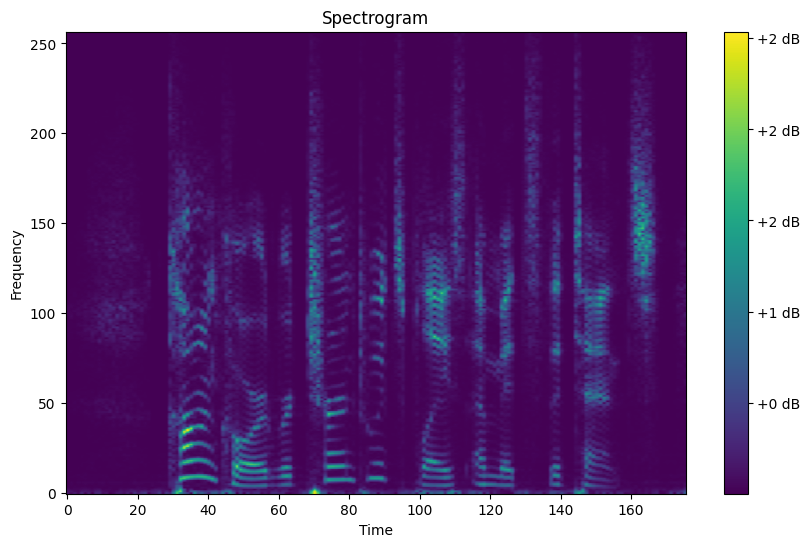

CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
torch.Size([1, 1, 257, 176])


In [37]:
inputs, targets, input_percentages, target_sizes, audio_dir = next(test_loader_iter) 
input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
inputs = inputs.to(device)
targets = targets.to(device)

plot_spectrogram(inputs.detach())
for idx in targets:
    print(model_ds.labels[idx], end='')
print()
# load inputs, targets, input_percentages, target_sizes from pickle data_loader_values.pkl
# import pickle
# with open( 'data_loader_values.pkl', 'rb') as f:
#     data = pickle.load(f)

print(inputs.shape)

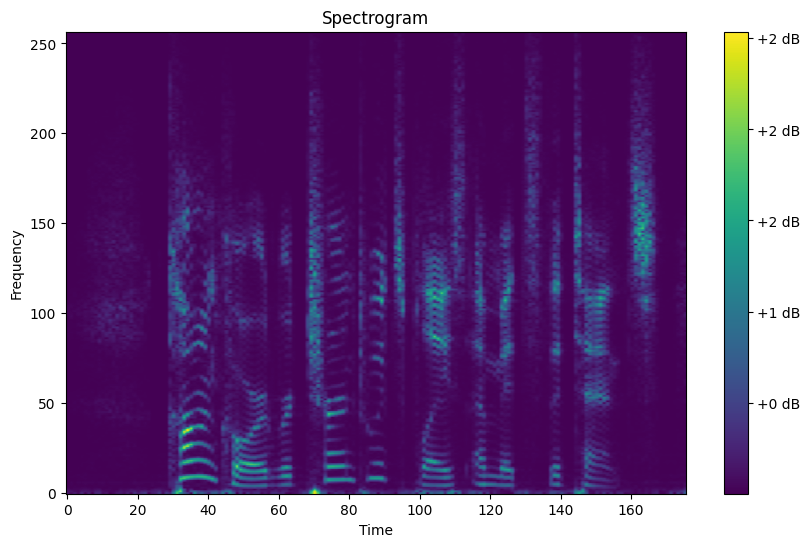

In [38]:
%matplotlib inline
plot_spectrogram(inputs.detach())

In [40]:
# ------------------------------------------------------------------------------
#  Loss function, get target dL/dW
# ------------------------------------------------------------------------------
##get the param to match gradient
weight_param = model_ds.fc[0].module[1].weight
# weight_param = model_simple.fc2.weight
print('weight shape:', weight_param.shape)

out, output_sizes, hs = model_ds(inputs, input_sizes) # 1 176 29

# make target same size of output size
targets = targets[-out.shape[1]:]
target_sizes[0]= len(targets)


print('model input shape, input_sizes:', inputs.shape, input_sizes)
print('model output shape, output_sizes, hidden sizes:', out.shape, output_sizes, len(hs))
print('target sizes, targets: ', target_sizes, targets)

out = out.transpose(0, 1)  # TxNxH
out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log
# from torch.nn import CTCLoss
# loss_ = CTCLoss(blank=model_ds.labels.index('_'), reduction='sum', zero_infinity=True)(out, targets, output_sizes, target_sizes)
loss_func = lambda x,y :ctc_loss_imp(x, y, output_sizes, target_sizes,reduction='mean')


loss_func_lib   = torch.nn.CTCLoss()
loss = loss_func(out, targets)
loss_lib = loss_func_lib(out, targets, output_sizes, target_sizes)
print('loss:', loss.item())
print('loss by pt lib:', loss_lib.item())
# grab gradient to match
dldw_target= torch.autograd.grad(loss, weight_param)[0]

print('grad shape:',dldw_target.shape, 'grad_norm', dldw_target.norm())


weight shape: torch.Size([29, 1024])
model input shape, input_sizes: torch.Size([1, 1, 257, 176]) tensor([176], dtype=torch.int32)
model output shape, output_sizes, hidden sizes: torch.Size([1, 88, 29]) tensor([88], dtype=torch.int32) 5
target sizes, targets:  tensor([46], dtype=torch.int32) tensor([ 4, 16, 15,  4, 16, 19,  5, 28, 19,  6, 21, 22, 19, 15,  6,  5, 28, 21,
        16, 28, 10, 21, 20, 28, 17, 13,  2,  4,  6, 28,  2, 14, 10,  5, 20, 21,
        28, 21,  9,  6, 28, 21,  6, 15, 21, 20], device='cuda:0')
loss: 4.657453081087393
loss by pt lib: 4.6574530601501465
grad shape: torch.Size([29, 1024]) grad_norm tensor(4.9769, device='cuda:0')


In [41]:
preds = (torch.argmax(out.exp(),dim=-1).squeeze()).detach().cpu().numpy().tolist()

In [42]:
for idx in preds:
    print(model_ds.labels[idx], end='')
print()

DDNNR_IIZEXLLKKKKUUUUUUUNPPPBBOOOYWWWBEEEEHHHHFFXAJJZ__  VV ZHHHH'LIIOI___GGAAAAOUACPPHH


In [43]:
# ------------------------------------------------------------------------------
# Meta loss
# ------------------------------------------------------------------------------
def meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param):
    loss = loss_func(output, targets)
    dldw = torch.autograd.grad(loss, weight_param, create_graph=True)[0]
    loss = ((dldw-dldw_target)**2).sum() #MSE
    #loss = 1 - torch.nn.functional.cosine_similarity(dldw.reshape(1,-1), dldw_target.reshape(1,-1))

    return loss,dldw


# out, output_sizes, hs = model_ds(x_param, input_sizes) # 1 176 29
# #out = model_ds(x_hat,input_sizes)
# out = out.transpose(0, 1)  # TxNxH
# out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

# loss,dldw = meta_loss(out, targets, None, None, dldw_target,  weight_param)
# print('loss, dldw norm:', loss.item(), torch.norm(dldw))

In [44]:

# ------------------------------------------------------------------------------
# Init random input
# ------------------------------------------------------------------------------
# FREQ_CUT_OFF=100

x_init = torch.rand_like (inputs).to(device)
x_init = x_init- 0.4
x_init = x_init/ 2
print('init mean, std:', x_init.mean(), x_init.std())

# x_pad  = torch.ones( (inputs.shape[0],inputs.shape[1], inputs.shape[2]-FREQ_CUT_OFF, inputs.shape[3])
#                     ).mul(1e-03).to(device)

x_param = torch.nn.Parameter(x_init.to(device),requires_grad=True)
# x_param_full = torch.concat([x_param, x_pad], dim=2)

# plot_tensor_distribution(x_param_full)

init mean, std: tensor(0.0495, device='cuda:0') tensor(0.1439, device='cuda:0')


In [45]:
# ------------------------------------------------------------------------------
# Train
# ------------------------------------------------------------------------------
import torch.optim as optim

optimizer = optim.Adam([x_param], lr=.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=.5,patience=1000)
# scheduler = torch.optim.lr_scheduler.MultiStepLR( optimizer, milestones= [2000, 2500, 3000, 3500], gamma=0.5)

i=0
loss_history = []
loss_gm_history = []
loss_reg_history = []

In [46]:
def tv_norm( x):
    # Compute differences along the y-axis
    dy = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :])
    # Compute differences along the x-axis
    dx = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1])
    # Compute total variation
    tv = torch.sum(dx) + torch.sum(dy)
    # Scale by the strength parameter
    return tv

In [47]:
while True:
    # x_param_full= torch.concat([x_param, x_pad], dim=2)
    out, output_sizes, hs = model_ds(x_param, input_sizes) # 1 176 29
    out = out.transpose(0, 1)  # TxNxH
    out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

    # mloss, dldw_f = meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param)
    mloss, dldw_f = meta_loss(out, targets, None, None, dldw_target,  weight_param)
    regloss = tv_norm(x_param)
    # L2 regularize
    # mloss += 1e-03 * torch.mean(x_param)
    # TV 
    
    loss = 0.95* mloss + 0.05* regloss



    optimizer.zero_grad()
    loss.backward()
    grad = x_param.grad.data

    # torch.nn.utils.clip_grad_norm_(x_param, 1.0)
    optimizer.step()
    scheduler.step(loss)

    ## PROJECT NON NEGATIVE
    # x_param = x_param.clamp(min=0)
    # with torch.no_grad():
    x_param.data = torch.clamp( x_param.data, min=0)


    loss_history.append(loss.item())
    loss_gm_history.append(mloss.item() )
    loss_reg_history.append(regloss.item() )

    if i % 10 == 0:
        print('Iteration, Loss (A-G-R), Gradient Norm, Learning Rate: {:4d}, {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(i, loss.item(), mloss.item(), regloss.item()
         , grad.norm().item(), optimizer.param_groups[0]["lr"]))
        # scheduler.step(mloss.item())

    if i % 100 == 0:
        # x_params_to_plot = torch.concat( [x_param, x_pad], dim=2)
        plot_four_graphs(inputs.detach(), x_param.detach(), loss_history, loss_gm_history,loss_reg_history ,i)
        

    i+=1

Iteration, Loss (A-G-R), Gradient Norm, Learning Rate:    0, 809.8345, 61.0286, 15037.1484, 77.1983, 0.1000


In [ ]:
mloss

In [ ]:
plot_four_graphs(inputs.detach(), x_param.detach(), loss_history,i)

In [ ]:
plot_value_distribution_input_reconstructed(inputs.detach(), x_param.detach())

In [ ]:
tv_norm(x_param)

In [ ]:

# def plot_tensor_distribution(x_param):
#     import seaborn as sns
#     """
#     Plot the distribution of values within a tensor.
    
#     Args:
#         x_param (torch.Tensor): The tensor to analyze.
#     """
#     plt.figure(figsize=(10, 6))
#     sns.histplot(x_param.cpu().numpy().flatten(), bins=50, kde=True)
#     plt.title('Distribution of Tensor Values')
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
# save the current x_param to file using torch.save
torch.save(x_param, 'x_param.pt')



In [ ]:
x_params_to_plot = torch.concat( [x_param, x_pad], dim=2)
# save figure with name that has date time hour min and epoch number
import datetime
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d-%H-%M")
plot_four_graphs(inputs.detach(), x_params_to_plot.detach(), loss_history)
plt.savefig('figures/{}_{}.png'.format(now, i))
        

In [ ]:
while True:
    x_param_full= torch.concat([x_param, x_pad], dim=2)
    out, output_sizes, hs = model_ds(x_param_full, input_sizes) # 1 176 29
    out = out.transpose(0, 1)  # TxNxH
    out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

    # mloss, dldw_f = meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param)
    mloss, dldw_f = meta_loss(out, targets, None, None, dldw_target,  weight_param)


    optimizer.zero_grad()
    mloss.backward()
    grad = x_param.grad.data

    optimizer.step()
    scheduler.step(mloss.item())

    ## PROJECT NON NEGATIVE
    # x_param = x_param.clamp(min=0)
    # with torch.no_grad():
    x_param.data = torch.clamp( x_param.data, min=0)


    loss_history.append(mloss.item())

    if i % 10 == 0:
        print('Iteration, Loss, Gradient Norm, Learning Rate: {:4d}, {:.4f}, {:.4f}, {:.4f}'.format(i, mloss.item(), grad.norm().item(), optimizer.param_groups[0]["lr"]))
        scheduler.step(mloss.item())

    if i % 1000 == 0:
        x_params_to_plot = torch.concat( [x_param, x_pad], dim=2)
        plot_four_graphs(inputs.detach(), x_params_to_plot.detach(), loss_history)

    i+=1

In [ ]:
for g in optimizer.param_groups:
    g['lr']=0.1


In [ ]:
x_params_to_plot.transpose(2,3).squeeze().mean(dim=0)

In [ ]:
model_ds.

In [ ]:

inputs.transpose(2,3).squeeze().mean(dim=0)

## Plot sth

In [ ]:
def plot_tensor_distribution(x_param):
    import seaborn as sns
    """
    Plot the distribution of values within a tensor.
    
    Args:
        x_param (torch.Tensor): The tensor to analyze.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(x_param.cpu().numpy().flatten(), bins=50, kde=True)
    plt.title('Distribution of Tensor Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
plot_tensor_distribution(x_param.detach())

In [ ]:
plot_tensor_distribution(inputs.detach())

In [ ]:
inputs.min()

In [ ]:
import numpy as np
np.log(1+7.9e-05)

In [ ]:
x_params.var()

In [ ]:
import seaborn as sns
def plot_tensor_distribution(x_param):
    """
    Plot the distribution of values within a tensor.
    
    Args:
        x_param (torch.Tensor): The tensor to analyze.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(x_param.cpu().numpy().flatten(), bins=50, kde=True)
    plt.title('Distribution of Tensor Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
inputs_TF = inputs.transpose(-1,-2)

In [ ]:
inputs_TF.mean(dim=2)

In [ ]:
def plot_stem_tensor(tensor):
    """
    Plot a flattened version of a tensor in a stem plot to visualize how values change.
    
    Args:
        tensor (torch.Tensor): The tensor to be plotted.
    """
    plt.figure(figsize=(12, 4))
    flattened_tensor = tensor.flatten().cpu().numpy()
    plt.stem(range(len(flattened_tensor)), flattened_tensor, use_line_collection=True)
    plt.title('Stem Plot of Tensor Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

In [ ]:
plot_stem_tensor(inputs_TF.mean(dim=2))

In [ ]:
model_ds.fc[0]

In [ ]:
def band_compression(tensor, bands=10):
    """
    Perform band compression on a tensor.
    
    Args:
    - tensor: Input tensor of shape (T x F), where T is the number of time steps and F is the number of frequency bins.
    - bands: Number of frequency bands to compress.
    
    Returns:
    - Compressed tensor.
    """
    T, F = tensor.shape
    compressed_tensor = torch.zeros((T, F // bands+1), dtype=tensor.dtype, device=tensor.device)
    for i in range(0, F, bands):
        compressed_tensor[:, i // bands] = torch.mean(tensor[:, i:i+bands], dim=1)
    return compressed_tensor
    
def band_decompression(tensor, original_shape, bands=10):
    """
    Perform band decompression on a compressed tensor.
    
    Args:
    - tensor: Compressed tensor of shape (T x F'), where T is the number of time steps and F' is the number of compressed frequency bands.
    - original_shape: Tuple containing the original shape of the tensor before compression (T x F).
    - bands: Number of frequency bands used for compression.
    
    Returns:
    - Decompressed tensor.
    """
    T, F = original_shape
    decompressed_tensor = torch.zeros((T, F), dtype=tensor.dtype, device=tensor.device)
    for i in range(0, F, bands):
        band_values = tensor[:, i // bands].unsqueeze(1)
        decompressed_tensor[:, i:i+bands] = band_values
    return decompressed_tensor

In [ ]:
inputs_flat = inputs.squeeze()

In [ ]:
inputs_flat.shape

In [ ]:
inputs_compressed = band_compression(inputs_flat.T).T
inputs_decompressed = band_decompression(inputs_compressed.T, inputs.squeeze().T.shape,10)

In [ ]:
plot_spectrogram(inputs_compressed)

In [ ]:
plot_spectrogram(inputs)

In [ ]:
plot_spectrogram(inputs_decompressed.T)